# Travelling Salesman Problem Reinforcement Learning - Cross Entropy

The travelling salesman problem is a classic optimisation problem, where the aim is to find the fastest or shortest route between a numebr of cities, returning to the base city at the end.

### RL involves:
* Trial and error search
* Receiving and maximising reward (often delayed)
* Linking state -> action -> reward
* Must be able to sense something of their environment
* Involves uncertainty in sensing and linking action to reward
* Learning -> improved choice of actions over time
* All models find a way to balance best predicted action vs. exploration

### Elements of RL
* *Environment*: all observable and unobservable information relevant to us
* *Observation*: sensing the environment
* *State*: the perceived (or perceivable) environment 
* *Agent*: senses environment, decides on action, receives and monitors rewards
* *Action*: may be discrete (e.g. turn left) or continuous (accelerator pedal)
* *Policy* (how to link state to action; often based on probabilities)
* *Reward signal*: aim is to accumulate maximum reward over time
* *Value function* of a state: prediction of likely/possible long-term reward from a particular state
* *Q*: prediction of likely/possible long-term reward from performing a particular *action*
* *Model* (optional): a simulation of the environment

## Cross Entropy

Cross entropy is a policy method (it seeks to recommend actions without any estimation of the value of a state or action). The basic method is:

1. Play *k* episodes using current model and environment
2. Calculate total reward for each episode
3. Keep best episodes (e.g. top 50%)
4. Train on remaining episodes using observations and actions taken
5. Repeat

![](./images/cross_entropy.png)

## Import

Import required liraries (including environment and plotting libraries in `env` folder).

In [1]:
from collections import deque
from env.tsp_env import TspEnv
from env import tsp_plots
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim

## Set number of cities to visit

In [2]:
NUMBER_OF_CITIES = 10

## Set stopping conditions

Stop if any of the following are true:

In [3]:
MAXIMUM_BATCHES = 5000
MAXIMUM_TIME_MINS = 120
NO_IMPROVEMENT_BATCHES = 250
NO_IMPROVEMENT_TIME = 120

## Define neural net

In [4]:
class Net(nn.Module):
    """
    Pytorch neural net using the flexible pytorch nn.Modlule class.
    Note: the neural net output is linear. To convert these to probabilities for
    each action (sum to 1.0) a SoftMax activation on the final output is
    required, but this is applied outside of the net itself, which improves
    speed and stability of training.

    Layers in model:
    * Input layer (implied, takes the number of observations)
    * Densely connected layer (size = 4 x number of observations)
    * ReLU activation
    * Densely connected layer (size = 4 x number of observations)
    * ReLU activation
    * Output layer (size = number of possible actions)

    (A SoftMax layer will be added later)
    """

    def __init__(self, observation_space, action_space):
        """Define layers of sequential net"""
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, NUMBER_OF_CITIES * 4),
            nn.ReLU(),
            nn.Linear(NUMBER_OF_CITIES * 4, NUMBER_OF_CITIES * 4),
            nn.ReLU(),
            nn.Linear(NUMBER_OF_CITIES * 4, NUMBER_OF_CITIES * 4),
            nn.ReLU(),
            nn.Linear(NUMBER_OF_CITIES * 4, action_space)
        )
        
        
    def forward(self, x):
        """Define forward pass (simple, as using a pre-defined sequential
        model)"""
        
        # Move input to required device (GPU or CPU)
        # Pass through net
        return self.net(x)

In [5]:
def play_episode(env, model, observation_space):
    """Play an episode"""

    # Define softmax layer
    sm = nn.Softmax(dim=1)

    # Reset trackers and environment
    episode_reward = 0
    obs_tracker = []
    action_tracker = []

    # Reset environment (returns first observation)
    obs, reward, is_terminal, info = env.reset()

    # Loop up to 200 steps
    for step in range(500):

        # Track observations
        obs = np.float32(obs)
        obs_tracker.append(obs)

        # Get action probability (put obs in Tensor first)
        obs = torch.FloatTensor([obs])
        act_probs = model(obs)
        act_probs = sm(act_probs)
        act_probs = act_probs.data.numpy()[0]

        # Get and track action: action sampled based on probability distribution
        np.random.seed()
        action = np.random.choice(len(act_probs), p=act_probs)
        action_tracker.append(action)

        # Take action
        obs, reward, done, info = env.step(action)
        episode_reward += reward

        # Pole has fallen over if done is True
        if done:
            break

    # Put results in dictionary
    results = {'episode_reward': episode_reward,
               'episode_obs': obs_tracker,
               'episode_actions': action_tracker}

    return results

In [6]:
def filter_episodes(results, percentile_cutoff=70):
    """Get best episodes"""

    # Get episode rewards & define cuttoff
    episode_rewards = [episode['episode_reward'] for episode in results]
    reward_cutoff = np.percentile(episode_rewards, percentile_cutoff)
    
    # Get best route
    best_route_index = np.argmax(episode_rewards)
    
    all_actions = actions = [episode['episode_actions'] for episode in results]
    best_route = all_actions[best_route_index]

    # Get best episode observations and actions
    obs = [episode['episode_obs'] for episode in results if
           episode['episode_reward'] >= reward_cutoff]

    actions = [episode['episode_actions'] for episode in results if
               episode['episode_reward'] >= reward_cutoff]

    # Convert list of observation arrays into a numpy array
    obs = np.vstack(obs)

    # Flatten actions list and convert to NumPy
    actions = [item for sublist in actions for item in sublist]
    actions = np.array(actions)
    
    return obs, actions, best_route

In [7]:
def main():
    
    ############################## Set up model ################################

    # Set number of episodes to play before slecting best and updating net
    episode_batch_size = 50

    # Set up environment
    time_start = time.time()
    env = TspEnv(number_of_cities = NUMBER_OF_CITIES)

    # Get number of observations from environemt(allows the env to change)
    # Obs = array of visited cities and on-ehot array of current city
    obs_size = env.observation_space.shape[0] * 2

    # Get number of actins from environemnt
    n_actions = len(env.action_space)

    # Set up Neural Net
    model = Net(obs_size, n_actions)
    objective = nn.CrossEntropyLoss()
    learning_rate = 0.003
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

    # Play batches of episodes
    batch_count = 0

    # Lists to store results
    all_results_batch_number = []
    all_results_average_reward = []
    all_results_maxumum_reward = []
    last_results = deque(maxlen = 10)
    
    # Track best
    best_reward = -9999999
    best_average_reward = -9999999
    best_route = None
    
    # Set batch and time of last best route
    batch_last_best = 0
    time_last_best = time.time()

    ################## Play batch of epsiodes and select best ##################
    
    # Start playing loop and continue until goal performance reached
    while True:
        # Play episodes
        batch_count += 1
        batch_results = []
        for episode in range(episode_batch_size):
            results = play_episode(env, model, obs_size)
            batch_results.append(results)

        # Get average and maximum reward
        rewards = [episode['episode_reward'] for episode in batch_results]
        average_reward = np.mean(rewards)
        maximum_reward = np.max(rewards)
        
        # Get best runs
        training_obs, training_actions, batch_best_route = \
            filter_episodes(batch_results)
        training_obs = torch.Tensor(training_obs)
        training_actions = torch.Tensor(training_actions).long()        
   
        # Check whether best route is better than previously discovered
        if maximum_reward > best_reward:
            best_reward = maximum_reward
            best_route = batch_best_route
        
        if average_reward > best_average_reward:
            best_average_reward = average_reward
            batch_last_best = batch_count
            time_last_best = time.time()
            time_elapsed = (time.time() - time_start) / 60
            print(f'\nNew best average. Batch : {batch_count: 5.0f},  ' \
                  f'Time {time_elapsed: 4.0f}  ' \
                  f'Average reward {average_reward: 6.0f}')

        # Store and print results
        all_results_batch_number.append(batch_count)
        all_results_average_reward.append(average_reward)
        all_results_maxumum_reward.append(maximum_reward)
        last_results.append(average_reward)

        print(f'\rBatch {batch_count:3}. Average and best run: ' \
              f'{average_reward:6.0f}, {maximum_reward:6.0f}. ', end="")
        
        # Check for stopping
        stop = False
        if batch_count == MAXIMUM_BATCHES:
            stop = True
        elif time.time() - time_start > MAXIMUM_TIME_MINS * 60:
            stop = True
        elif time.time() - time_last_best > NO_IMPROVEMENT_TIME * 60:
            stop = True
        elif batch_count - batch_last_best > NO_IMPROVEMENT_BATCHES:
            stop = True
        elif average_reward == maximum_reward:
            # Model converged so all runs identical
            stop = True
  
        if stop:
            break 

        
        ############### Train model on best episodes from batch ################
       
        # Reset model gradients
        optimizer.zero_grad()
        # Predict actions
        action_scores = model(training_obs)
        # Calculate loss between predicted and actual actions
        loss_v = objective(action_scores, training_actions)
        # Back propgate losses
        loss_v.backward()
        # Update model weights
        optimizer.step()
        
    ############################# Plot results #################################
        
    # Plot result progress
    tsp_plots.plot_result_progress_cross_entropy(
        all_results_batch_number, 
        all_results_average_reward, 
        all_results_maxumum_reward)
    
    # Plot best route
    co_ords = env.state.city_locations
    best_route = [0] + best_route
    route_co_ords = [co_ords[i] for i in best_route]
    tsp_plots.plot_route(best_route, route_co_ords)
    
    ###################### Show route and distances ############################
    
    print ('Route')
    print (best_route)
    print ()
    print ('Best route distance')
    print (f'{env.state.calculate_distance(best_route):.0f}')


New best average. Batch :     1,  Time    0  Average reward   -849
Batch   2. Average and best run:   -874,    655. 
New best average. Batch :     3,  Time    0  Average reward   -680
Batch   6. Average and best run:   -695,    804. 
New best average. Batch :     7,  Time    0  Average reward   -616
Batch   9. Average and best run:   -738,    541. 
New best average. Batch :    10,  Time    0  Average reward   -601
Batch  12. Average and best run:  -1002,    520. 
New best average. Batch :    13,  Time    0  Average reward   -529
Batch  23. Average and best run:   -724,    642. 
New best average. Batch :    24,  Time    0  Average reward   -440
Batch  36. Average and best run:   -455,    869. 
New best average. Batch :    37,  Time    1  Average reward   -419
Batch  47. Average and best run:   -522,    670. 
New best average. Batch :    48,  Time    1  Average reward   -417
Batch  49. Average and best run:   -503,    387. 
New best average. Batch :    50,  Time    1  Average reward   -

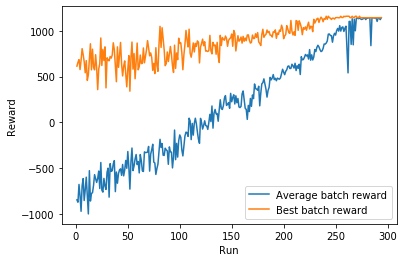

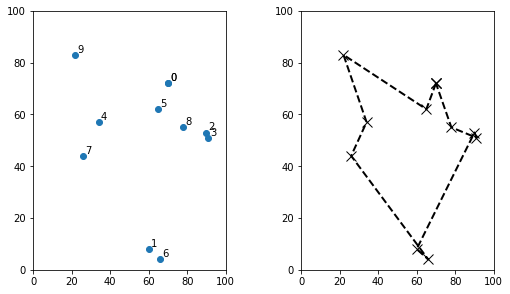

Route
[0, 5, 9, 4, 7, 6, 1, 2, 3, 8, 0]

Best route distance
255


In [8]:
main()